# Reto 6
#### Estudiante: Manuela Góez Estepa

El motivo de estudio a lo largo del siguiente notebook será el Lóbulo de Roche, el cual hace referencia a la región de influencia en que una partícula de prueba es dominada gravitacionalmente por un cuerpo específico de un sistema binario. Nótese que ello corresponde a un problema de tres cuerpos restringido, en el que hay dos partículas masivas y se pretende determinar o predecir el movimiento de una partícula de masa despreciable con respecto a las otras dos.

En muchas ocasiones se suele aproximar el lóbulo de Roche como una región esférica, no obstante, tal aseveración no es correcta, puesto que en los modelos, se puede observar ésta más como una gota. A continuación se pretende implementar el Método de Montecarlo, un procedimiento estadístico para estimar, en este caso, el volumen que ocupa una región desconocida generando N puntos arbitrarios en una zona que la incluya y contabilizando aquellos que estén "dentro" del sector de estudio.

Luego de analizar las variaciones volumétricas del lóbulo para diferentes valores de $\alpha$ se introduce el concepto del Radio de Roche, precisando el radio de la esfera cuyo volumen equivale al encerrado por el Lóbulo.

In [ ]:
#@markdown Librerías
!wget https://github.com/seap-udea/MecanicaCeleste-Zuluaga/raw/master/pymcel.tgz &> /dev/null
!tar zxvf pymcel.tgz &> /dev/null
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect, newton
from pymcel.export import funcion_puntos_colineales,constante_jacobi
from numpy import array,meshgrid,zeros_like,linspace
from tqdm import tqdm

# 1. Volumen del Lóbulo de Roche y Radio de Roche para un parámetro α arbitrario.


En primer lugar sabemos que en un problema de tres cuerpos restrigido, el parámetro $\alpha$ permite conocer diversos valores y "constantes" del sistema, lógicamente teniendo en cuenta las condiciones en las que se estudia el sistema, como un sistema de referencia rotante, unas unidades canónicas únicas para cada caso, entre otros. Por consiguiente, se propone una Clase CR3BP que incluye el cálculos útiles:

*   Posición de los puntos colineales de Lagrange.
*   Distancia de un punto cualquiera P(x,y,z) a los cuerpos principales M1,M2.
*   El Potencial modificado y la constante de Jacobi en un punto arbitrario.
*   Gráfica de





In [ ]:
#@markdown Clase: Los objetos CR3BP tienen como atributo un valor α

class CR3BP:

  def __init__(self,alfa):
    self.alfa=alfa

  def alfa_value(self):
    return self.alfa

  def pos_L1_L2(self):  #está sobre entendido que la posición es en x, pues L1 y L2 son los puntos L colineales
    xL1=bisect(funcion_puntos_colineales,0,1-2*self.alfa,args=(self.alfa,))
    xL2=bisect(funcion_puntos_colineales,1-0.5*self.alfa,2,args=(self.alfa,))
    return xL1,xL2

  def r1_r2(self,X,Y,Z):
    r1=np.sqrt((X+self.alfa)**2+Y**2+Z**2)
    r2=np.sqrt((X-1+self.alfa)**2+Y**2+Z**2)
    return r1,r2

  def Vmod(self,X,Y,Z):
    r1,r2=self.r1_r2(X,Y,Z)
    Vmod=-(1-self.alfa)/r1-self.alfa/r2-0.5*(X**2+Y**2)
    return Vmod

  def CJ(self,r,v): #recuerde que r y v se deben pasar así [[x,y,z]],[[vx,vy,vz]]
    CJ=constante_jacobi(self.alfa,r,v)[0]
    return CJ

  def Grafica_Potencial(self,rango=[[-1.5,1.5],[-1.5,1.5]],NG=100):  #donde rango es una lista [[x1,x2],[y1,y2]]
    xL1,xL2=self.pos_L1_L2()
    CJ_L1=self.CJ([[xL1,0,0]],[[0,0,0]])
    Vmod_L1=-CJ_L1/2

    #Malla coordenada
    X,Y=meshgrid(linspace(rango[0][0],rango[0][1],NG),linspace(rango[1][0],rango[1][1],NG))
    Z=zeros_like(X)

    #Distancia relativa
    r1,r2=self.r1_r2(X,Y,Z)

    #Calcula el potencial
    Vmod=self.Vmod(X,Y,Z)

    #Gráfico
    fig=plt.figure(figsize=(5,5))
    ax=fig.gca()

    #Contornos
    ax.contour(X,Y,Vmod,levels=[Vmod_L1],colors='k',linestyles='solid');
    ax.contourf(X,Y,Vmod,levels=linspace(-3,Vmod.max(),100),cmap="jet");

    #Posición de los puntos de Lagrange
    ax.plot([xL1],[0],'w+',ms=10);
    ax.plot([xL2],[0],'w+',ms=10);

    #Esfera de Hill
    from matplotlib.patches import Circle
    ax.add_patch(Circle([1-self.alfa,0],(self.alfa/3)**(1./3),color='w',fill=None,linestyle='--'));

    #Decoración
    ax.set_title(f"CRTBP para $\\alpha={self.alfa}$");

    return fig,ax

In [ ]:
#@markdown Datos correspondientes a α=0.1

modelo1=CR3BP(0.1)

α=modelo1.alfa_value()           #Párametro CR3BP
L1,L2=modelo1.pos_L1_L2()        #Coordenadas x de L1 y L2
V_L1=modelo1.Vmod(L1,0,0)        #Potencial Modificado en L1
r1,r2=modelo1.r1_r2(L1,0,0)      #Distancia de L1 a M1 y M2

Para aplicar el método de Montecarlo se debe definir la región en que se generarán las partículas aleatorias, de modo que se conoce el valor del volumen en que fueron arrojadas el total de partículas (Por simplicidad se escoge definir el sector como un cubo).

El volumen del Lóbulo de Roche será:

\begin{equation}
V_{lobulo}=\frac{N_{dentro}}{N_{total}}V_{conocido}
\end{equation}

Como se conoce que la forma del lóbulo es similar a una gota, arbitrariamente se elige el volumen encerrado como una caja de la siguiente manera:


Veamos que la atura $z$ de la caja se obtiene encontrando el valor para el cual el potencial modificado es es igual al que hay en $L_1$ y donde las coordenadas $x,y$ coinciden con el cuerpo.

LA definición del potencial modificado es:

\begin{equation}
V_{mod}=-\frac{1-\alpha}{\sqrt{(x+\alpha)^2+y^2+z^2}}-\frac{\alpha}{\sqrt{(x+\alpha-1)^2+y^2+z^2}}-\frac{1}{2}(x^2+y^2)
\end{equation}

Tomando (para $M_2$) $x=1-\alpha$ y $y=0$ en la línea equipotencial de L1, entonces:

\begin{equation}
V_{mod_{L1}}=-\frac{1-\alpha}{\sqrt{1+z_2^2}}-\frac{\alpha}{|z_2|}-\frac{1}{2}(1-2\alpha+\alpha^2)
\end{equation}

Para $M_1$ $x=-\alpha$ y $y=0$:

\begin{equation}
V_{mod_{L1}}=-\frac{1-\alpha}{|z_1|}-\frac{\alpha}{\sqrt{1+z_1^2}}-\frac{1}{2}\alpha^2
\end{equation}

In [ ]:
#@markdown Valor de $z$ de la caja.
def f_m1(z):
  f=-(1-α)/(abs(z))-α/(1+z**2)**0.5-0.5*(α**2)-V_L1
  return f

def f_m2(z):
  f=-(1-α)/(1+z**2)**0.5-α/abs(z)-0.5*(1-2*α+α**2)-V_L1
  return f

z1=newton(f_m1,r1)
z2=newton(f_m2,r2)

100%|██████████| 10000/10000 [00:27<00:00, 367.78it/s]


Volumen Lóbulo de Roche 0.04 u.c.
Radio de Roche 0.21 u.c.


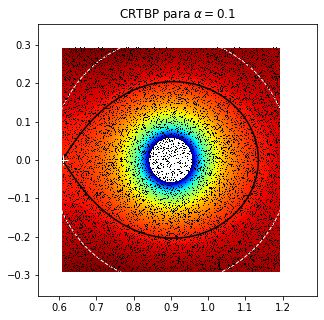

In [ ]:
#@markdown Monte Carlo para el Lóbulo del $M_2$
dots_in=0
N=int(1e4)

#Se muestra el gráfico para ilustrar la situación
modelo1.Grafica_Potencial(rango=[[1-α-r2,1-α+r2],[-r2,r2]])

for i in tqdm(range(N)):
  xi=np.random.uniform(L1,L1+2*r2)
  yi=np.random.uniform(-r2,r2)
  zi=np.random.uniform(-z2,z2)
  plt.plot(xi,yi,"k,")

  if modelo1.Vmod(xi,yi,zi)<V_L1:
    dots_in+=1

vol_caja=2*r2*2*r2*2*z2 #base es 2r2, altura 2r2 y profundidad 2z
vol_lobulo=dots_in/N*vol_caja  #unidades canónicas
print(f"Volumen Lóbulo de Roche {vol_lobulo:.2f} u.c.")

#Despejando R del volumen de una esfera
R_roche1=((3/4)*vol_lobulo/np.pi)**(1/3)
print(f"Radio de Roche {R_roche1:.2f} u.c.")

100%|██████████| 10000/10000 [00:08<00:00, 1204.93it/s]


Volumen Lóbulo de Roche 0.79 u.c.
Radio de Roche 0.57 u.c.


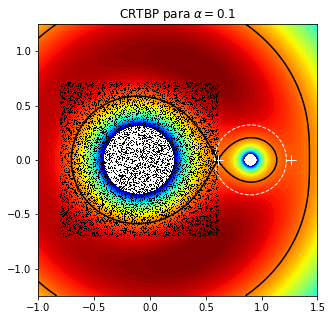

In [ ]:
#@markdown Monte Carlo para el Lóbulo del $M_1$
dots_in=0
N=int(1e4)

#Se muestra el gráfico para ilustrar la situación
modelo1.Grafica_Potencial(rango=[[-1,1.5],[-1.25,1.25]])

for i in tqdm(range(N)):
  xi=np.random.uniform(-α-r1,-α+r1)  #Note que (1-α-L1) es la distancia entre m2 y L1.
  yi=np.random.uniform(-r1,r1)
  zi=np.random.uniform(-z1,z1)
  plt.plot(xi,yi,"k,")

  if modelo1.Vmod(xi,yi,zi)<V_L1:
    dots_in+=1

vol_caja=2*r1*2*r1*2*z1 #base es 2r2, altura 2r2 y profundidad 2z
vol_lobulo=dots_in/N*vol_caja  #unidades canónicas
print(f"Volumen Lóbulo de Roche {vol_lobulo:.2f} u.c.")

#Despejando R del volumen de una esfera
R_roche2=((3/4)*vol_lobulo/np.pi)**(1/3)
print(f"Radio de Roche {R_roche2:.2f} u.c.")

Para corroborar los resultados, se compara con una función empírica para el radio de Roche:

\begin{equation}
R_{roche}=\frac{0.49q^{2/3}}{0.6q^{2/3}+ln(1+q^{1/3})}
\end{equation}

en donde $q=m_2/m_1$. Recordando que $\alpha=\mu_2$ y $1-\alpha=\mu_1$, entonces, para el radio de Roche alrededor del cuerpo primario $q=\frac{1-\alpha}{\alpha}$ y en el caso del cuerpo secundario $q=\frac{\alpha}{1-\alpha}$.

In [ ]:
#@markdown Función empírica del Radio de Roche
def RL(α,primario=True):
  if primario==False:q=α/(1-α)            #En caso de que se desee el valor del Radio para el lóbulo secundario
  else:q=(1-α)/α
  return 0.49*q**(2/3)/(0.6*q**(2/3)+np.log(1+q**(1/3)))

In [ ]:
#@markdown
print(f"""El radio de Roche con la función empírica para el
lóbulo del cuerpo primario es {RL(α,True):.2f} u.c y con el método de Monte Carlo
se halló que R es {R_roche2:.2f} u.c.

Alrededor del cuerpo secundario el radio de Roche con la función empírica
 es {RL(α,False):.2f} u.c y con el método de Monte Carlo
se halló que R es {R_roche1:.2f} u.c.
""")

El radio de Roche con la función empírica para el 
lóbulo del cuerpo primario es 0.57 u.c y con el método de Monte Carlo 
se halló que R es 0.57 u.c.

Alrededor del cuerpo secundario el radio de Roche con la función empírica
 es 0.21 u.c y con el método de Monte Carlo 
se halló que R es 0.21 u.c.



Con lo anterior, se puede evidenciar que la estimación del volumen del lóbulo y en consecuencia el radio de Roche es bastante precisa generando N=10000 puntos.

# 2. Radio de Roche para valores α desde 0.01 a 0.5 alrededor del cuerpo primario.

In [ ]:
alfa_s=np.linspace(0.01,0.5,500)
R_s=np.zeros(len(alfa_s))
R_formula=np.zeros(len(alfa_s))

A continuación se define una función con un procedimiento análogo al anterior punto.

In [ ]:
#@markdown Función de método de Montecarlo para lóbulo primario
def montecarlo(α,N=int(1e4)):

  #creación del sistema
  modelo=CR3BP(α)

  #Datos del modelo
  L1,L2=modelo.pos_L1_L2()        #Coordenadas x de L1 y L2
  V_L1=modelo.Vmod(L1,0,0)        #Potencial Modificado en L1
  r1,r2=modelo.r1_r2(L1,0,0)      #Distancia de L1 a M1 y M2

  #z para la caja
  z1=newton(f_m1,r1)

  #generación de puntos
  dots_in=0

  for i in range(N):
    xi=np.random.uniform(-α-r1,-α+r1)
    yi=np.random.uniform(-r1,r1)
    zi=np.random.uniform(-z1,z1)

    if modelo.Vmod(xi,yi,zi)<V_L1:
      dots_in+=1

  #Volumen del lóbulo
  vol_caja=2*r1*2*r1*2*z1
  vol_lobulo=dots_in/N*vol_caja

  #Radio de Roche
  R_roche=((3/4)*vol_lobulo/np.pi)**(1/3)

  return R_roche

In [ ]:
#@markdown Radios de Roche para distintos valores de $\alpha$

for i in tqdm(range(len(alfa_s))):
  R_s[i]=montecarlo(alfa_s[i])
  R_formula[i]=RL(alfa_s[i],True)  #Se guardan los valores para comparar luego.

100%|██████████| 500/500 [01:18<00:00,  6.36it/s]


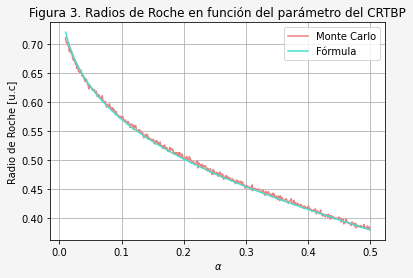

In [ ]:
#@markdown Gráfica comparativa entre los radios por Monte Carlo y por la Fórmula Empírica

plt.figure(facecolor="whitesmoke")
plt.title("Figura 3. Radios de Roche en función del parámetro del CRTBP")
plt.plot(alfa_s,R_s,color="lightcoral",label="Monte Carlo")
plt.plot(alfa_s,R_formula,color="turquoise",label="Fórmula")
plt.xlabel(r"$\alpha$")
plt.ylabel("Radio de Roche [u.c]")
plt.legend()
plt.grid()

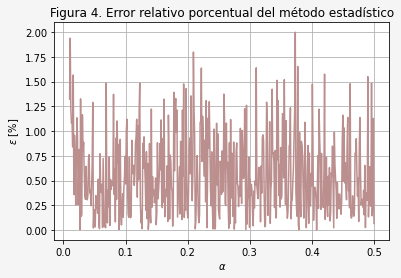

In [ ]:
#@markdown Gráfica del error del método Monte Carlo con respecto a la aproximación empírica
plt.figure(facecolor="whitesmoke")
plt.title("Figura 4. Error relativo porcentual del método estadístico")

#El error relativo es el error absoluto/valor real *100%
plt.plot(alfa_s,abs(R_s-R_formula)/R_formula*100,color="rosybrown")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\epsilon \ [\%]$")
plt.grid()

**Conclusiones**

El método de Monte Carlo es un alternativa computacional poderosa al momento de determinar un volumen desconocido o complicado de precisar matemáticamente, por lo tanto, se deben definir con cautela los puntos generados y el criterio al cual serán sometidos. En este caso, para el lóbulo primario se crearon N=10000 puntos, con lo que se pudo puntualizar el Radio de Roche con un error relativo inferior al 2% para la mayoría de los $\alpha$ entre 0.01 y 0.5. Así mismo se reconoce que al escoger un N más grande el valor estadístico se aproximará más al empírico, no obstante, las figuras 3 y 4 muestran que el método converge satisfactoriamente y no es oportuno comprometer más recursos computacionales para conseguir un error levemente menor. Sin embargo, si se define mejor la creación de los puntos, por ejemplo, definiendo el volumen conocido como el de una esfera (en comparación con la "caja"), se puede lograr más precisión con el mismo número de puntos.